# LAB | Making predictions with logistic regression

In [39]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import neighbors

In [13]:
password = getpass.getpass()

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

##### 1 - 2. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [65]:
query = '''SELECT f.title as film_title,
                f.film_id,
                  f.rental_duration,
                  f.rental_rate,
                  f.rating,
                  f.length,
                  f.replacement_cost,
                  COUNT(DISTINCT r.rental_id) AS rental_count,
                  COUNT(DISTINCT i.inventory_id) AS inventory_count,
                  COUNT(DISTINCT fa.actor_id) AS actor_count,
                  CASE
                      WHEN f.title IN
                          (SELECT DISTINCT f.title as film_title
                           FROM film f
                           JOIN inventory i USING (film_id)
                           JOIN rental USING (inventory_id)
                           WHERE rental.rental_date LIKE "2005-05%%")
                      THEN "1"
                      ELSE "0"
                  END AS rented_in_may
          FROM film f
          LEFT JOIN inventory i USING (film_id)
          LEFT JOIN rental r USING (inventory_id)
          LEFT JOIN film_category fc USING (film_id)
          LEFT JOIN film_actor fa USING (film_id)
          GROUP BY f.film_id;'''

film = pd.read_sql_query(query, engine)
film

,film_title,film_id,rental_duration,rental_rate,rating,length,replacement_cost,rental_count,inventory_count,actor_count,rented_in_may
0,ACADEMY DINOSAUR,1,6,0.99,PG,86,20.99,23,8,10,1
1,ACE GOLDFINGER,2,3,4.99,G,48,12.99,7,3,4,0
2,ADAPTATION HOLES,3,7,2.99,NC-17,50,18.99,12,4,5,1
3,AFFAIR PREJUDICE,4,5,2.99,G,117,26.99,23,7,5,1
4,AFRICAN EGG,5,6,2.99,G,130,22.99,12,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,996,6,0.99,G,183,9.99,7,2,5,0
996,YOUTH KICK,997,4,0.99,NC-17,179,14.99,6,2,5,0
997,ZHIVAGO CORE,998,6,0.99,NC-17,105,10.99,9,2,6,1
998,ZOOLANDER FICTION,999,5,2.99,R,101,28.99,17,5,5,1


In [66]:
query1 = 'SELECT fc.film_id, c.name AS category_name FROM film_category fc JOIN category c USING (category_id)'
film_category = pd.read_sql_query(query1, engine)
film_category

,film_id,category_name
0,19,Action
1,21,Action
2,29,Action
3,38,Action
4,56,Action
...,...,...
995,931,Travel
996,977,Travel
997,981,Travel
998,988,Travel


##### 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [67]:
film = pd.merge(left=film,right=film_category,how = 'inner',left_on = 'film_id', right_on='film_id')
film = film.drop("film_id", axis=1)

film.head(10)

,film_title,rental_duration,rental_rate,rating,length,replacement_cost,rental_count,inventory_count,actor_count,rented_in_may,category_name
0,ACADEMY DINOSAUR,6,0.99,PG,86,20.99,23,8,10,1,Documentary
1,ACE GOLDFINGER,3,4.99,G,48,12.99,7,3,4,0,Horror
2,ADAPTATION HOLES,7,2.99,NC-17,50,18.99,12,4,5,1,Documentary
3,AFFAIR PREJUDICE,5,2.99,G,117,26.99,23,7,5,1,Horror
4,AFRICAN EGG,6,2.99,G,130,22.99,12,3,5,1,Family
5,AGENT TRUMAN,3,2.99,PG,169,17.99,21,6,7,1,Foreign
6,AIRPLANE SIERRA,6,4.99,PG-13,62,28.99,15,5,5,0,Comedy
7,AIRPORT POLLOCK,6,4.99,R,54,15.99,18,4,4,1,Horror
8,ALABAMA DEVIL,3,2.99,PG-13,114,21.99,12,5,9,0,Horror
9,ALADDIN CALENDAR,6,4.99,NC-17,63,24.99,23,7,8,0,Sports


In [69]:
# visualize data types for splitting
film.dtypes

film_title           object
rental_duration       int64
rental_rate         float64
rating               object
length                int64
replacement_cost    float64
rental_count          int64
inventory_count       int64
actor_count           int64
rented_in_may        object
category_name        object
dtype: object

In [70]:
# check for null values
film.isna().sum()

film_title          0
rental_duration     0
rental_rate         0
rating              0
length              0
replacement_cost    0
rental_count        0
inventory_count     0
actor_count         0
rented_in_may       0
category_name       0
dtype: int64

In [71]:
# confirm value distribution of new column
film['rented_in_may'].value_counts()

1    686
0    314
Name: rented_in_may, dtype: int64

/var/folders/nn/t4c1n2z11_g_hd91q77nxzb80000gn/T/ipykernel_57057/609402311.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_matrix = film.corr()


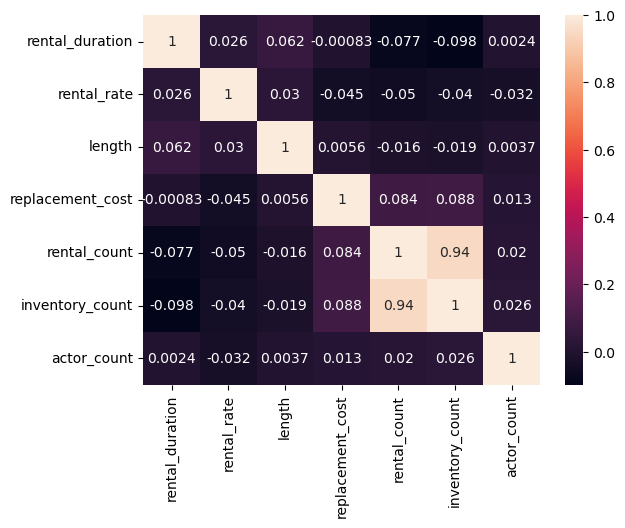

In [72]:
# look for correlation amongst variables
# we cannot confirm corr with target as it is categorical
correlations_matrix = film.corr()
sns.heatmap(correlations_matrix, annot=True)  
plt.show()

We see a very high correlation between inventory count and rental count, so we are keeping one of them (dropping inventory_count). 

##### 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [73]:
#x-y split
X = film.drop('rented_in_may', axis = 1)
y = film['rented_in_may']

In [90]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 400)

In [104]:
# X-split - numerical
X_train_num = X_train.select_dtypes(include = np.number)
X_train_num = X_train_num.drop('inventory_count', axis = 1)


# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)

X_train_norm

,rental_duration,rental_rate,length,replacement_cost,rental_count,actor_count
0,0.25,0.5,0.654676,0.80,0.65625,0.400000
1,0.25,1.0,0.151079,0.00,0.34375,0.333333
2,0.00,1.0,0.446043,0.20,0.34375,0.200000
3,0.25,0.5,0.007194,0.65,0.93750,0.533333
4,1.00,0.5,0.575540,0.50,0.68750,0.266667
...,...,...,...,...,...,...
795,0.75,1.0,1.000000,0.10,0.50000,0.533333
796,1.00,1.0,0.194245,0.45,0.00000,0.333333
797,0.25,0.5,0.568345,0.65,0.78125,0.133333
798,0.00,0.5,0.438849,0.20,0.53125,0.133333


In [105]:
# X-split - categorical
X_train_categorical = X_train.select_dtypes(include = object)
X_train_categorical = X_train_categorical.drop('film_title', axis = 1) # drop film_title as they're all unique values and will distort the encoder

# Scaling data
encoder = OneHotEncoder().fit(X_train_categorical)

X_train_cat_encoded = encoder.transform(X_train_categorical).toarray()
X_train_encoded = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out()) 

X_train_encoded

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,...,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
797,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
798,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# build X_train and y_train
X_train_transformed = np.concatenate([X_train_norm, X_train_encoded], axis=1)

In [107]:
# build logistic regression model classification
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [115]:
# transform X_test - numerical
X_test_num = X_test.select_dtypes(include = np.number)
X_test_num = X_test_num.drop('inventory_count', axis = 1)

# Scaling data
# we use the transformer and encoder that were trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.head()

,0,1,2,3,4,5
0,0.50,0.0,0.683453,0.00,0.78125,0.333333
1,0.25,0.5,0.496403,0.20,0.34375,0.466667
2,0.25,0.5,0.431655,0.05,0.50000,0.333333
3,0.50,1.0,0.669065,0.85,0.84375,0.266667
4,0.00,1.0,0.956835,0.90,0.84375,0.333333


In [116]:
# transform X_test - categorical
X_test_categorical = X_test.select_dtypes(include = object)
X_test_categorical = X_test_categorical.drop('film_title', axis = 1)

X_test_cat_encoded = encoder.transform(X_test_categorical).toarray()
X_test_encoded = pd.DataFrame(X_test_cat_encoded, columns=encoder.get_feature_names_out()) 

X_test_encoded

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,...,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
196,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# concatenate X_test num and cat for predictions
X_test_transformed = np.concatenate([X_test_norm, X_test_encoded], axis=1)

##### 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [118]:
# make predictions on test set
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test) 

0.82

In [119]:
# check prediction values count
pd.Series(predictions).value_counts()

1    164
0     36
dtype: int64

In [126]:
# compared against true values count
pd.Series(y_test).value_counts()

1    142
0     58
Name: rented_in_may, dtype: int64

##### 6. Evaluate the results.

Comparing both values, we confirm that our model trails a difference of around 20 counts. 

In [120]:
# let's see confusion matrix insights
confusion_matrix(y_test, predictions)

array([[ 29,  29],
       [  7, 135]])

##### Using Nearest Neighbors classifier

In [121]:
# KNN classifier to compare 
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)

KNeighborsClassifier(n_neighbors=3)

In [122]:
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.635

In [123]:
confusion_matrix(y_test, predictions_clf)

array([[ 17,  41],
       [ 32, 110]])

In [124]:
pd.Series(y_test).value_counts()

1    142
0     58
Name: rented_in_may, dtype: int64

In [125]:
pd.Series(predictions_clf).value_counts()

1    151
0     49
dtype: int64

Using the neighbors classifier gives us a lower percentage on our model score, making it less accurate. 